# Modelling of Georgia

## Initial Loading of Packages and data

Small naming correction made for spelling mistakes

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Visualizers
import shap
import matplotlib.pyplot as plt

In [2]:
training=pd.read_pickle('data/GA_pickled/training.pkl')
testing=pd.read_pickle('data/GA_pickled/testing.pkl')

In [3]:
training=training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})
testing=testing.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})

In [4]:
# Features are obtained from georga_models
features=['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_avg_dormrooms_stem']

training.per_capita_income=training.per_capita_income.astype(int)

training[features].head()

,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
11412,25522,37629,64.752872,45.445749,49.345304,142.383194,64.752872,22914.0,8495.2,2734.2,22160.2,22914.0,4832.0,865.6,900.0,5104.8,4832.0
2950,46326,33989,100.679037,41.332505,26.639010,160.939720,101.641207,35029.8,7709.6,2840.0,21914.8,34447.6,7275.0,589.6,727.4,5643.6,7334.6
15267,28054,41448,120.888047,37.451584,87.037513,148.319049,120.888047,22914.0,6462.2,2822.8,18512.8,22914.0,4832.0,936.0,1137.8,4134.0,4832.0
11107,17169,35045,171.944485,70.312743,121.874600,201.848758,187.907911,21680.4,5299.4,2871.2,18512.8,22202.2,3934.6,808.6,914.8,4134.0,3704.4
3555,15591,32088,113.802670,56.196530,92.018660,182.601619,132.201269,26267.4,7350.0,2585.2,22071.6,26007.8,5853.8,387.0,898.0,5065.4,6179.0


In [5]:
x_train = training.drop(['COUNTY','SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude','year'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
X_train.head()

,const,population,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem,per_capita_income
11412,1.0,25522,64.752872,45.445749,49.345304,142.383194,64.752872,22914.0,8495.2,2734.2,22160.2,22914.0,4832.0,865.6,900.0,5104.8,4832.0,37629
2950,1.0,46326,100.679037,41.332505,26.639010,160.939720,101.641207,35029.8,7709.6,2840.0,21914.8,34447.6,7275.0,589.6,727.4,5643.6,7334.6,33989
15267,1.0,28054,120.888047,37.451584,87.037513,148.319049,120.888047,22914.0,6462.2,2822.8,18512.8,22914.0,4832.0,936.0,1137.8,4134.0,4832.0,41448
11107,1.0,17169,171.944485,70.312743,121.874600,201.848758,187.907911,21680.4,5299.4,2871.2,18512.8,22202.2,3934.6,808.6,914.8,4134.0,3704.4,35045
3555,1.0,15591,113.802670,56.196530,92.018660,182.601619,132.201269,26267.4,7350.0,2585.2,22071.6,26007.8,5853.8,387.0,898.0,5065.4,6179.0,32088


## initial models

In [6]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrnt_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [7]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 1.706334025715024e-08
p-value of full compared to university metric model: 4.719374533718744e-09
p-value of university metric compared to university distance model: 2.658963419983089e-05


In [8]:
uni_features = [x for x in features if "closest_five" in x]
nonuni_features = [x for x in features if "closest_five" not in x]
features_wo_dormrooms = [x for x in features if "dormrooms" not in x]
coordinates = ['Latitude','Longitude']

In [9]:
#Full
fullmodel = LinearRegression()
fullmodel.fit(training[features],training['PERCENT_3_OR_ABOVE'])
# University
unimodel = LinearRegression()
unimodel.fit(training[uni_features],training['PERCENT_3_OR_ABOVE'])
# Population-income
nonunimodel = LinearRegression()
nonunimodel.fit(training[nonuni_features],training['PERCENT_3_OR_ABOVE'])
# No silly dorms
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(training[features_wo_dormrooms],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [10]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(georga_train[nonuni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(georga_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(georga_train[uni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(georga_holdout[uni_features]))

    ## Fit and get ho mse for no dorm rooms model

    nodorm_lr = LinearRegression()

    nodorm_lr.fit(georga_train[features_wo_dormrooms],georga_train['PERCENT_3_OR_ABOVE'])

    rmses[4, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nodorm_lr.predict(georga_holdout[features_wo_dormrooms]))

    i = i+1


In [11]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"no dorm rooms model Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 20.10320828817747 and STD: 2.2622224202466152
fullmodel Avg. CV RMSE: 18.14122242320947 and STD: 2.0942923904344113
nonuni model Avg. CV RMSE: 18.825756142689215 and STD: 2.583835227471473
uni model Avg. CV RMSE: 19.021103148117838 and STD: 2.1016857589666684
no dorm rooms model Avg. CV RMSE: 18.509950888664576 and STD: 2.0660604036893746


### Results initial fitting

Full and no uni models perform similarly with moderate optimization.

## PCA

In [12]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])

In [13]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [14]:
print(f'original feature size: {training_scaled.shape[1]}')
print(f'new feature size: {training_pca.shape[1]}')

original feature size: 17
new feature size: 9


### PCA results

Similar feature reduction is seen as to georga

## Ridge vs PCA vs Full Models

In [15]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [16]:
pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [17]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(georga_holdout[features]))
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


In [18]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 20.10320828817747 and STD: 2.2622224202466152
fullmodel Avg. CV RMSE: 18.14122242320947 and STD: 2.0942923904344113
PCA model Avg. CV RMSE: 17.930045998846744 and STD: 2.0779722255286432
Ridge model Avg. CV RMSE: 17.937524520022567 and STD: 1.9920899555977183


### Results of comparison

Ridge model is nearly indistinguishable from PCA model with marginal (thousandths) improvement over full model

## xgBoost modelling

In [19]:
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']

In [20]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [21]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:16.98445	validation-rmse:14.58568
[10]	train-rmse:5.02453	validation-rmse:11.09302
[20]	train-rmse:3.03070	validation-rmse:11.46039
[30]	train-rmse:1.84633	validation-rmse:11.69477
[40]	train-rmse:1.12776	validation-rmse:11.74870
[50]	train-rmse:0.79626	validation-rmse:11.84448
[60]	train-rmse:0.54316	validation-rmse:11.86139
[70]	train-rmse:0.38925	validation-rmse:11.87892
[80]	train-rmse:0.30939	validation-rmse:11.91141
[90]	train-rmse:0.26640	validation-rmse:11.91072
[100]	train-rmse:0.23320	validation-rmse:11.91993
[107]	train-rmse:0.21962	validation-rmse:11.92345


In [22]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[19.534426 62.085316 23.722452]


In [23]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,16.671488,0.324935,18.935842,0.758025
1,13.431666,0.378783,17.608555,0.477336
2,11.081159,0.309972,16.690398,0.475306
3,9.313445,0.311584,16.183151,0.875228
4,7.939302,0.289654,16.061227,0.955530


In [24]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 2.6486 +/- 0.1734
Validation RMSE: 15.3818 +/- 1.1867


In [25]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(georga_train[features], georga_train['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(georga_holdout[features],georga_holdout['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,            # Print rmse val every 50 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'],y_pred)
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


[0]	train-rmse:16.98445	validation-rmse:14.58568


[50]	train-rmse:0.79626	validation-rmse:11.84448
[100]	train-rmse:0.23320	validation-rmse:11.91993
[107]	train-rmse:0.21962	validation-rmse:11.92345
[0]	train-rmse:15.93980	validation-rmse:19.25340
[50]	train-rmse:0.76627	validation-rmse:12.32448
[100]	train-rmse:0.20749	validation-rmse:12.36454
[111]	train-rmse:0.19488	validation-rmse:12.36692
[0]	train-rmse:15.55579	validation-rmse:19.74576
[50]	train-rmse:0.75381	validation-rmse:14.46119
[100]	train-rmse:0.20465	validation-rmse:14.47470
[144]	train-rmse:0.16621	validation-rmse:14.47334
[0]	train-rmse:16.34512	validation-rmse:19.29610
[50]	train-rmse:0.70283	validation-rmse:16.53155
[100]	train-rmse:0.11412	validation-rmse:16.52781
[115]	train-rmse:0.06636	validation-rmse:16.52845
[0]	train-rmse:16.52946	validation-rmse:16.67600
[50]	train-rmse:0.91859	validation-rmse:13.09857
[100]	train-rmse:0.24482	validation-rmse:13.22614
[113]	train-rmse:0.21821	validation-rmse:13.23214


In [26]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 20.10320828817747 and STD: 2.2622224202466152
fullmodel Avg. CV RMSE: 18.14122242320947 and STD: 2.0942923904344113
xgboost model Avg. CV RMSE: 13.704861121550266 and STD: 1.6583245713198154
Ridge model Avg. CV RMSE: 17.937524520022567 and STD: 1.9920899555977183


### Results xgboost

xgBoost performs best on RMSD and Standard Deviation. 

## SHAP visualization

In [27]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

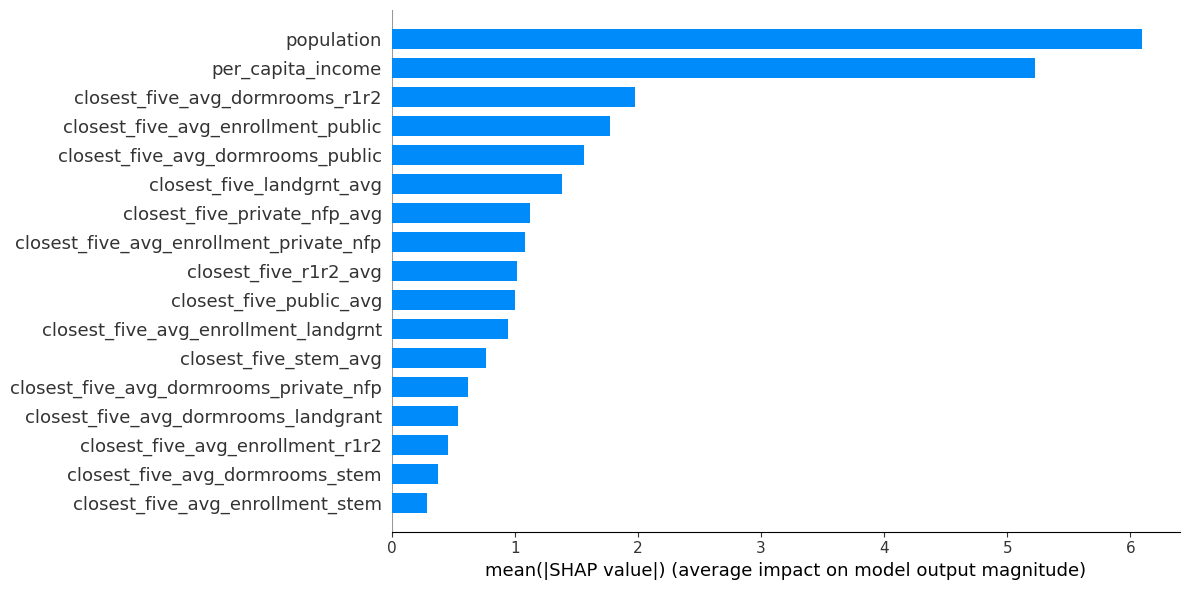

In [30]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

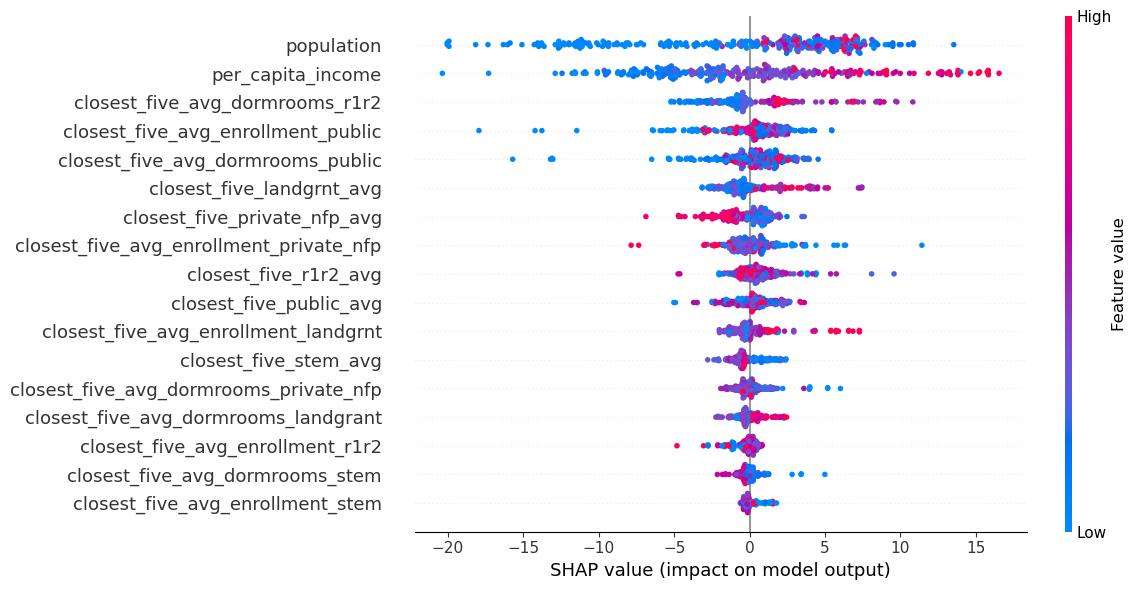

In [31]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()